In [ ]:
import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

import sys
sys.path.append("..")

from config import Config
from unimemrag.embedding.models.QwenTextEmbedding import QwenTextEmbedding
from unimemrag.retriever import ClipEmbedding
from unimemrag.memory_forest.memory_forest import MemoryForestStore

cfg = Config(collection="memtree")                          
embed_model = ClipEmbedding(model_name="../../ckpts/EVA-CLIP-8B", device_map="balanced", image_processor_name_or_path="../../ckpts/clip-vit-large-patch14")
text_embedder = QwenTextEmbedding(model_name="../../ckpts/Qwen3-Embedding-0.6B", model_kwargs={'device_map': "balanced"})
memforest_store = MemoryForestStore(cfg, vector_size=embed_model.dim, leaf_text_vector_size=text_embedder.dim)

In [ ]:
import os
from openai import OpenAI
from sklearn import tree
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"
import json
from pathlib import Path
from dataclasses import asdict
from itertools import islice
from tqdm.auto import tqdm
# import sys
# sys.path.append("..")
from unimemrag.memory_forest.memory_forest import build_tree, iter_wiki_dict
from unimemrag.utils.image_cache import download_images_for_kb, load_image_cache, replace_payload_image_urls, save_image_cache

llm = OpenAI(
       api_key="sk-d6de5f2c6e4c458e9b53e9d96a5e75bb",
       base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

KB_PATH = Path("../../benchmark/infoseek/subset/wiki_text/wiki_5k_dict.json")

with KB_PATH.open("r", encoding="utf-8") as fh:
    KB = json.load(fh)

IMAGE_CACHE_DIR = Path('../../benchmark/infoseek/subset/wiki_text/images_5k')
IMAGE_CACHE_INDEX = IMAGE_CACHE_DIR / "image_cache_index.json"
image_cache = load_image_cache(IMAGE_CACHE_INDEX)

if not image_cache:
    image_cache = download_images_for_kb(KB, IMAGE_CACHE_DIR, max_workers=64, resume=True)
    save_image_cache(image_cache, IMAGE_CACHE_INDEX)
else:
    print(f"Loaded {len(image_cache)} cached entries from {IMAGE_CACHE_INDEX}")

def localize_payload(payload):
    return replace_payload_image_urls(dict(payload), image_cache)


total = len(KB)
iterator = islice(iter_wiki_dict(KB), total)
iterator = tqdm(iterator, total=total, desc="Building Trees")

trees = []
for wiki_url, payload in iterator:
    payload = localize_payload(payload)
    # tree = build_tree(wiki_url, payload)
    tree = build_tree(
       wiki_url,
       payload,
       llm=llm,
       llm_model="qwen3-8b",
       max_summary_sections=None,
       llm_workers=10,
       llm_request_kwargs={"max_tokens": 512, "temperature": 0.7, "extra_body": {"enable_thinking": False}}
       )      
    trees.append(tree)

TREES_OUT = Path("trees_5k.json")
with TREES_OUT.open("w", encoding="utf-8") as fh:
    json.dump([asdict(t) for t in trees], fh, indent=2)
print(f"Saved {len(trees)} trees to {TREES_OUT}")

In [ ]:
'''
load trees from file
'''

import json
from pathlib import Path
from unimemrag.memory_forest.memory_forest import MemoryTree, RootNode, EventNode, LeafNode

TREES_OUT = Path("trees_5k.json")

with TREES_OUT.open("r", encoding="utf-8") as fh:
    data = json.load(fh)

def tree_from_dict(d):
    root = RootNode(**d["root"])
    events = [EventNode(**e) for e in d.get("events", [])]
    leaves = [LeafNode(**l) for l in d.get("leaves", [])]
    return MemoryTree(tree_id=d["tree_id"], root=root, events=events, leaves=leaves)

trees = [tree_from_dict(x) for x in data]

In [ ]:
# memforest_store.ingest_trees(
#       trees,
#       embed_model,
#       batch_size=256,
#       text_workers=16,
#       image_workers=16,
#       alpha=0.1,
#       show_progress=True
# )

# 入库：多模态 leaf
memforest_store.ingest_trees_new(
    trees,
    embed_model,
    leaf_text_embedder=text_embedder,
    beta=0.4,
    batch_size=64,        # mm_batch_size
    text_batch_size=16,    # text-only embedding batch
    text_workers=16,
    image_workers=16,
    show_progress=True,
)

In [1]:
"""
Loading tree index from memforest store
"""

import sys
sys.path.append('..')

import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

from config import Config
from unimemrag.embedding.models.ClipEmbedding import ClipEmbedding
from unimemrag.embedding.models.QwenTextEmbedding import QwenTextEmbedding
from unimemrag.memory_forest import MemoryForestStore

cfg = Config(collection="memtree")
embed_model = ClipEmbedding(model_name="../../ckpts/clip-vit-base-patch32", device_map="balanced")
text_embedder = QwenTextEmbedding(model_name="../../ckpts/Qwen3-Embedding-0.6B", model_kwargs={'device_map': "balanced"})
memforest_store = MemoryForestStore(cfg, vector_size=embed_model.dim, leaf_text_vector_size=text_embedder.dim)

/home/mobuser/miniconda3/envs/unimemrag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mobuser/miniconda3/envs/unimemrag/lib/python3.11/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['logit_scale']
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/mobuser/jjj/UniMemRAG/examples/../unimemrag/vector_store/qdrant.py:40: UserWarning: Qdrant client version 1.14.3 is incompatible with server version 1.16.3. Major versions sh

In [ ]:
# results = memforest_store.retrieve(
#     embed_model,
#     query_text="What is the closest parent taxonomy of this bird?",
#     query_image="../../benchmark/oven/05/oven_05037337.JPEG",
#     root_top_k=3,
#     event_top_k=3,
#     leaf_top_k=3,
#     alpha=0.3,
# )

# 检索：collapsed retrieval
results = memforest_store.collapsed_retrieve(
    embed_model,
    alpha=0.01,
    query_text="What is the length of the wingspan in millimetre of this insect?",
    query_image="../../benchmark/oven/05/oven_05036901",
    # query_image="https://oregonflora.org/dbimages/OFPimages/OFPImages_big/1522/DIG20072.jpg",
    leaf_text_embedder=text_embedder,
    leaf_top_k=500,
)

In [ ]:
# results[1].leaves
for result in results:
    print(result)

In [ ]:
for tree in results:
    print("=== Root:", tree.root.payload.get("topic"))
    for event in tree.events:
        sec_id = event.id
        meta = event.payload.get("metadata", {})
        title = meta.get("section_title") or event.payload.get("summary")
        section_chunks = [
            leaf.payload["content"]
            for leaf in tree.leaves.get(sec_id, [])
            if "content" in leaf.payload
        ]
        section_text = "\n".join(section_chunks)
        print(f"\nSection: {title}")
        print("Images:", meta.get("section_images", []))
        print("Text:", section_text)

In [2]:
memforest_store.client.delete_collection(memforest_store.cfg.collection)
memforest_store.client.delete_collection(memforest_store.event_collection)
memforest_store.client.delete_collection(memforest_store.leaf_collection)

True

In [ ]:
memforest_store.client.count(memforest_store.roof_collection, exact=True)
# memforest_store.client.count(memforest_store.leaf_collection, exact=True)

In [ ]:
for res in results:
    print(res.root.payload["topic"])
    print(res.events)

In [ ]:
from unimemrag.vlm.QwenVL import QwenVL
vlm = QwenVL(
    model_path="../../ckpts/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2",
)

In [ ]:
result = results[0]

def format_context(tree_result, top_sections=3, max_chars=1024):
    root = tree_result.root
    meta = root.payload.get("metadata", {}) or {}
    lines = [
        f"Topic: {root.payload.get('topic') or meta.get('source_url', 'n/a')}",
        f"Tree ID: {tree_result.tree_id}",
        f"Alignment score: {meta.get('alignment_best_score', 'n/a')}",
        "",
    ]
    for event in tree_result.events[:top_sections]:
        emeta = event.payload.get("metadata", {}) or {}
        title = emeta.get("section_title") or event.payload.get("summary") or "Unknown section"
        lines.append(f"Section: {title}")
        section_preview = (emeta.get("section_preview") or event.payload.get("summary") or "").strip()
        if section_preview:
            lines.append(section_preview)
        leaf_hits = tree_result.leaves.get(event.id, [])
        for idx, leaf_hit in enumerate(leaf_hits[:2], start=1):
            snippet = (leaf_hit.payload.get("content") or "").strip()
            if not snippet:
                continue
            lines.append(f"Paragraph {idx}: {snippet}")
        lines.append("")
    context = "\n".join(lines).strip()
    if max_chars and max_chars > 0 and len(context) > max_chars:
        truncated = context[:max_chars]
        if "\n" in truncated:
            truncated = truncated.rsplit("\n", 1)[0]
        context = truncated
    return context

context = format_context(result, top_sections=3)
print("formated_context:", context)
question="Who built this object that has not cash dispensing features?",

messages = [
    {"role": "system", "content": [
        {"type": "text", "text": "You are a helpful assistant. Please answer the question based on the context provided."}
    ]},
    {"role": "user", "content": [
        {"type": "image", "image": "../atm-machine.jpg"},
        {"type": "text",  "text": f"Here's the contexts:\n{context}\n\nNow, answer the question:\n{question}"}
    ]}
]
print(messages)

answer = vlm.chat(messages, max_new_tokens=32768, temperature=0.7)
print(answer)

In [ ]:
import os
os.environ.pop("http_proxy", None)
os.environ.pop("https_proxy", None)
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

import sys
sys.path.append("..")
from unimemrag.retriever import ClipEmbedding

# embed_model = ClipEmbedding(model_name="../../ckpts/clip-vit-base-patch32", device_map="balanced")

topic = "This is an Echinargus isola"
image_urls = [
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Echinargus_isola/0000_ced0c113175a.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Lycaena_hyllus/0000_ba081c18ae7a.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Edith_27s_checkerspot/0000_8219f8d41af1.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0000_dcc71c94ab92.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0001_03e01b10cf26.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0002_94d6d7d729ec.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0003_baaa1168c397.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0004_ae87b1fdb6e3.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0005_4d9ae010d696.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0006_272d182a9d3f.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Anacamptis_pyramidalis/0007_2d56e175d998.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0000_a9cc9f235e74.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0001_b2fbf15339e6.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0002_f50ffdc77bbc.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0003_2c785e6e913a.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0004_2c577d43a237.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0005_e958b2df7f33.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0006_5d87138706ab.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0007_7b229938e49e.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0008_4d2d362bff01.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Phoebis_sennae/0009_75d0765278a9.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Megisto_cymela/0000_715913a21a14.jpg",
    "../../benchmark/infoseek/subset/wiki_text/images_5k/https_en_wikipedia_org_wiki_Megisto_cymela/0001_4f7845429f54.jpg",
    "../oven_05031362.jpg",
    "../oven_05036901.jpg"
    ]


text_embed = embed_model.embed_texts([topic])[0]      # (dim,)
image_embeds = embed_model.embed_images(image_urls)   # (N, dim)

scores = image_embeds @ text_embed             # 余弦相似度
for url, score in zip(image_urls, scores):
    print(f"{url} -> {score:.4f}")

In [ ]:
from qdrant_client.http import models as qmodels

def scroll_all(client, collection, filter_):
    points = []
    offset = None
    while True:
        batch, offset = client.scroll(
            collection_name=collection,
            scroll_filter=filter_,
            with_payload=True,
            with_vectors=False,
            limit=256,
            offset=offset,
        )
        points.extend(batch)
        if offset is None or not batch:
            break
    return points

tree_id = "https://en.wikipedia.org/wiki/Echinargus_isola"

tree_filter = qmodels.Filter(
    must=[qmodels.FieldCondition(key="tree_id", match=qmodels.MatchValue(value=tree_id))]
)

roots = scroll_all(memforest_store.client, cfg.collection, tree_filter)
events = scroll_all(memforest_store.client, memforest_store.event_collection, tree_filter)
leaves = scroll_all(memforest_store.client, memforest_store.leaf_collection, tree_filter)

root_payload = roots[0].payload if roots else None
print("root:", root_payload)

print("events:", len(events))
for ev in events[:5]:
    print(ev.payload.get("summary"))

print("leaves:", len(leaves))
for leaf in leaves[:5]:
    print(leaf.payload.get("content"))

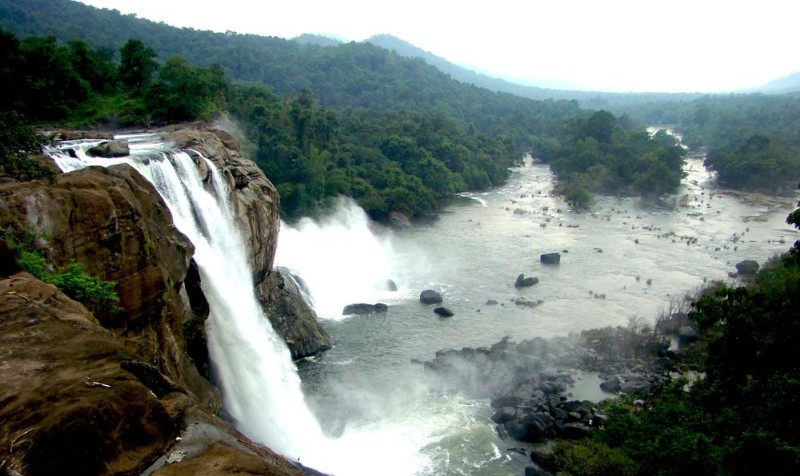

In [6]:
from PIL import Image
import sys
sys.path.append("..")
from infoseek_image_utils import resolve_images_root

# image_file = resolve_images_root("oven_05031362")
image_file = "../../benchmark/oven/08/oven_05012059.jpg"

# print(image_file)
img = Image.open(image_file)
img.show()